Original:
[[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
    6. ]
 [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
    3. ]
 [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
    7. ]
 [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
    3. ]
 [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
    3. ]]

Scaled:
[[ 0.94872647  0.68620244 -2.25177456  0.75752504 -0.2649003   2.394438
   1.01668424  0.01719733 -0.69663055  1.08733806  2.27457861 -0.71113139
   0.66000414]
 [ 1.39200191  0.68620244  0.87798549  1.61121989  0.76041519 -0.41763453
   1.01668424 -1.82190531  1.43548113  0.39718162  0.64911323  2.5048807
  -0.89023814]
 [ 1.39200191  0.68620244  0.87798549 -0.6652997  -0.34228261 -0.41763453
   1.01668424 -0.90235399  1.43548113  1.34614673  0.64911323  1.43287667
   1.17675157]
 [-1.93256387  0.68620244 -0.16526786 -0.0961698   0.06397448 -0.41763453
  -0.99674

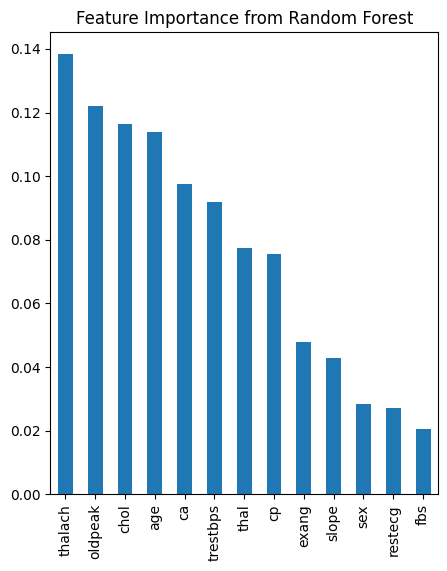

Selected Features via RFE: Index(['cp', 'restecg', 'oldpeak', 'ca', 'thal'], dtype='object')
Chi-Square p-values:
 thal        8.672776e-10
exang       2.083076e-08
ca          2.154659e-07
oldpeak     2.469786e-03
slope       7.147746e-03
cp          8.336977e-02
sex         1.117436e-01
restecg     1.343754e-01
fbs         1.550901e-01
thalach     5.356604e-01
age         8.706545e-01
trestbps    9.605862e-01
chol        9.963506e-01
dtype: float64

Selected features confirmed by at least 2 methods:
      thal   ca  restecg  cp  oldpeak
0     6.0  0.0        2   1      2.3
1     3.0  3.0        2   4      1.5
2     7.0  2.0        2   4      2.6
3     3.0  0.0        0   3      3.5
4     3.0  0.0        2   2      1.4
..    ...  ...      ...  ..      ...
298   7.0  0.0        0   1      1.2
299   7.0  2.0        0   4      3.4
300   7.0  1.0        0   4      1.2
301   3.0  1.0        2   2      0.0
302   3.0  0.0        0   3      0.0

[303 rows x 5 columns]

Logistic Regression:
Ac

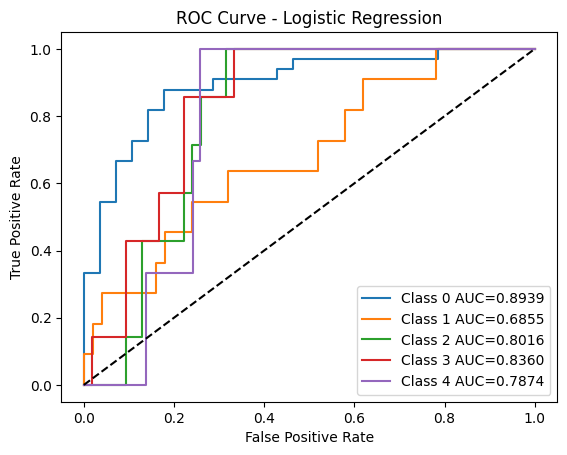


Decision Tree:
Accuracy: 0.3770
Precision: 0.4217
Recall: 0.3770
F1-score: 0.3973


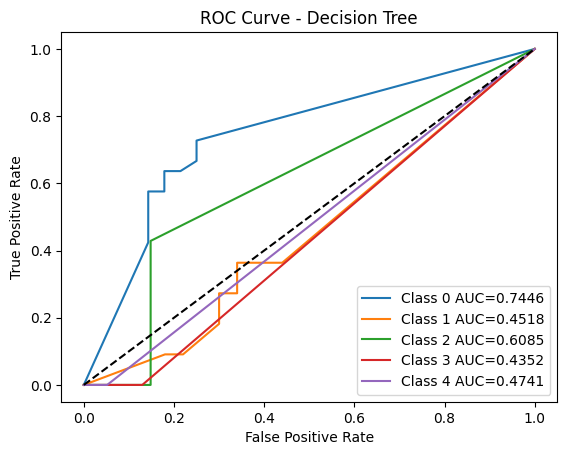


Random Forest:
Accuracy: 0.4754
Precision: 0.4887
Recall: 0.4754
F1-score: 0.4820


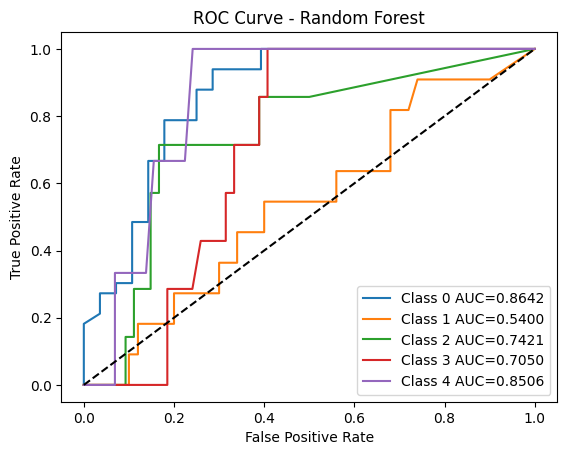


Support Vector Machine:
Accuracy: 0.5738
Precision: 0.5208
Recall: 0.5738
F1-score: 0.5424


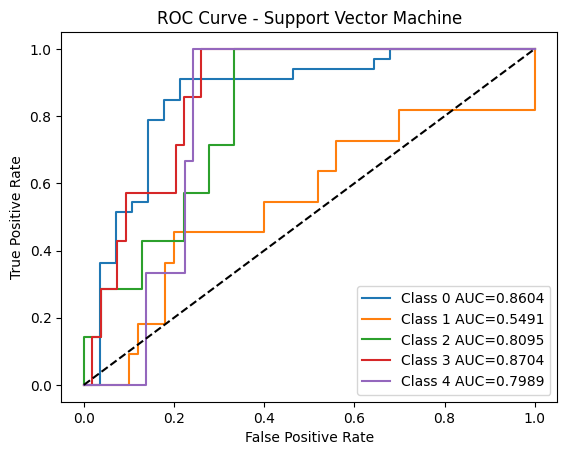

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from supervised_learning import X_train, X_test, y_train, y_test, models, y_test_bin
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
from joblib import dump
from pathlib import Path

In [2]:
###Hyperparameter Tuning###

# Define parameter grids for GridSearchCV/RandomizedSearchCV
param_grids = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"], "max_iter": [1000]},
    "Decision Tree": {"max_depth": [None, 5, 10, 15], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 5, 10], "min_samples_split": [2, 5], "min_samples_leaf": [1, 2]},
    "Support Vector Machine": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
}

# Store baseline results (from previous classification)
baseline_results={}
for name, model in  models.items():
    y_pred= model.predict(X_test)
    baseline_results[name]= accuracy_score(y_test,y_pred)

# Tune models and compare# Tune models and compare
optimized_models={}
optimized_results={}

for name,model in models.items():
    print(f"\nTuning {name}...")

    grid= GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    random= RandomizedSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1, n_iter=5, random_state=42)
    random.fit(X_train, y_train)

    # Choose the best between grid and random
    best_model= grid.best_estimator_ if grid.best_score_>= random.best_score_ else random.best_estimator_
    optimized_models[name]= best_model

    # Evaluate optimized model
    y_pred_opt= best_model.predict(X_test)
    optimized_results[name]= accuracy_score(y_test,y_pred)

# Compare baseline vs optimized
print("\nBaseline vs Optimized Accuracy:")
for name in models.keys():
     print(f"{name} Basline= {baseline_results[name]:.4f}, Optimized= {optimized_results[name]:.4f}")

# Identify best performing optimized model    
best_model_name = max(optimized_results, key=optimized_results.get)
best_model = optimized_models[best_model_name]
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nBest Performing Model after Hyperparameter Tuning: {best_model_name}")
print(f"Accuracy of Best Model on Test Set: {best_accuracy:.4f}")

# Save evaluation metrics

# Make sure results folder exists
os.makedirs('results', exist_ok=True)

metrics_lines = []

# Re-run metrics collection for saving
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    metrics_lines.append(f"{name}:\n"
                         f"Accuracy: {acc:.4f}\n"
                         f"Precision: {prec:.4f}\n"
                         f"Recall: {rec:.4f}\n"
                         f"F1-score: {f1:.4f}\n"
                         f"ROC AUC: {auc:.4f}\n\n")

# Write metrics to file
with open("results/evaluation_metrics.txt", "w") as f:
    f.writelines(metrics_lines)

print("\nMetrics saved to results/evaluation_metrics.txt")




Tuning Logistic Regression...

Tuning Decision Tree...

Tuning Random Forest...

Tuning Support Vector Machine...

Baseline vs Optimized Accuracy:
Logistic Regression Basline= 0.5738, Optimized= 0.5738
Decision Tree Basline= 0.3770, Optimized= 0.5738
Random Forest Basline= 0.4754, Optimized= 0.5738
Support Vector Machine Basline= 0.5738, Optimized= 0.5738

Best Performing Model after Hyperparameter Tuning: Logistic Regression
Accuracy of Best Model on Test Set: 0.5738

Metrics saved to results/evaluation_metrics.txt


In [3]:
###Model Export & Deployment###


# Current folder (notebook folder) as project root
project_root = Path().resolve()

# Make sure models folder exists
models_folder = project_root / 'models'
models_folder.mkdir(parents=True, exist_ok=True)

# Create and fit pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Save the pipeline to a .pkl file in the models folder
pipeline_file = models_folder / 'final_model.pkl'
dump(pipeline, pipeline_file)
print(f"\nModel pipeline saved as '{pipeline_file}'")


Model pipeline saved as 'C:\Users\Tasneem\OneDrive\Desktop\Heart_Disease_Project\models\final_model.pkl'
